#### Example code to calculate quantiles by day of year

In [1]:
import xarray as xr
import numpy as np

In [6]:
! ls /g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_19[7-9]*

/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1970.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1971.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1972.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1973.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1974.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1975.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1976.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1977.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1978.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1979.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1980.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1981.nc
/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/sm_pct_1982.nc
/g/data/fj8/BoM/AWRA/DATA

In [7]:
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/'
sm_files = 'sm_pct_*.nc'

# soil moisture data as degree of saturation; read in the data
ds_sm_temp = xr.open_mfdataset(awra_dir + sm_files)

time_slice = slice('1981-01-01', '2021-12-31')
lat_sel = -37
lon_sel = 148

# get data at a grid point
da_sm = ds_sm_temp.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_sm = da_sm.load()

# create empty lists to save the calculated quantiles
list_doy = []
list_da_quant = []

# create a new dimension named window. "window" contains 13 days: 6 days before, 6 days after & the day
# use data from "window" to calculate percentile for each day of the year (doy)
for doy, sample in da_sm.rolling(time=13, center=True).construct(time='window').groupby('time.dayofyear'):
    da_quant_bydoy = sample.load().quantile([0.1, 0.3], dim=['time', 'window'])
    list_doy.append(doy)
    list_da_quant.append(da_quant_bydoy)

In [8]:
# list_da_quant contains 366 elements - one for each day of year
# concatenate the data to create a dimension named dayofyear - this takes a few minutes to run
ds_sm_pct_perc = xr.concat(list_da_quant, dim = 'dayofyear').assign_coords({'dayofyear': list_doy})
ds_sm_pct_perc

<xarray.Dataset>
Dimensions:    (dayofyear: 366, quantile: 2)
Coordinates:
  * quantile   (quantile) float64 0.1 0.3
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    sm_pct     (dayofyear, quantile) float64 0.3572 0.4912 ... 0.4161 0.4995

In [49]:
year_start = '1981'
year_end = '2021'

da_sm_yr = da_sm.sel(time = slice(year_start, year_end))
da_sm_yr_doy = da_sm_yr['time.dayofyear'].values

da_sm_10p = ds_sm_pct_perc['sm_pct'].sel(quantile = 0.1, dayofyear = da_sm_yr_doy)
da_sm_10p = da_sm_10p.rename({'dayofyear':'time'}).assign_coords({'time': da_sm_yr.time.values})

da_sm_30p = ds_sm_pct_perc['sm_pct'].sel(quantile = 0.3, dayofyear = da_sm_yr_doy)
da_sm_30p = da_sm_30p.rename({'dayofyear':'time'}).assign_coords({'time': da_sm_yr.time.values})

In [50]:
da_sm_yr

<xarray.Dataset>
Dimensions:    (time: 14975)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Data variables:
    sm_pct     (time) float32 0.6913 0.6736 0.6561 ... 0.7105 0.6923 0.6748
Attributes:
    var_name:       sm_pct
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    url:            http://www.bom.gov.au/water/landscape
    title:          Australian Landscape Water Balance AWRA-L Model Version 6
    email:          awrams@bom.gov.au
    date_created:   2018-11-02T12:18:48
    source:         AWRA-L-v6)
    Description:    This data is provided by the Bureau of Meteorology and ca...
    date_modified:  2018-11-02T12:18:48

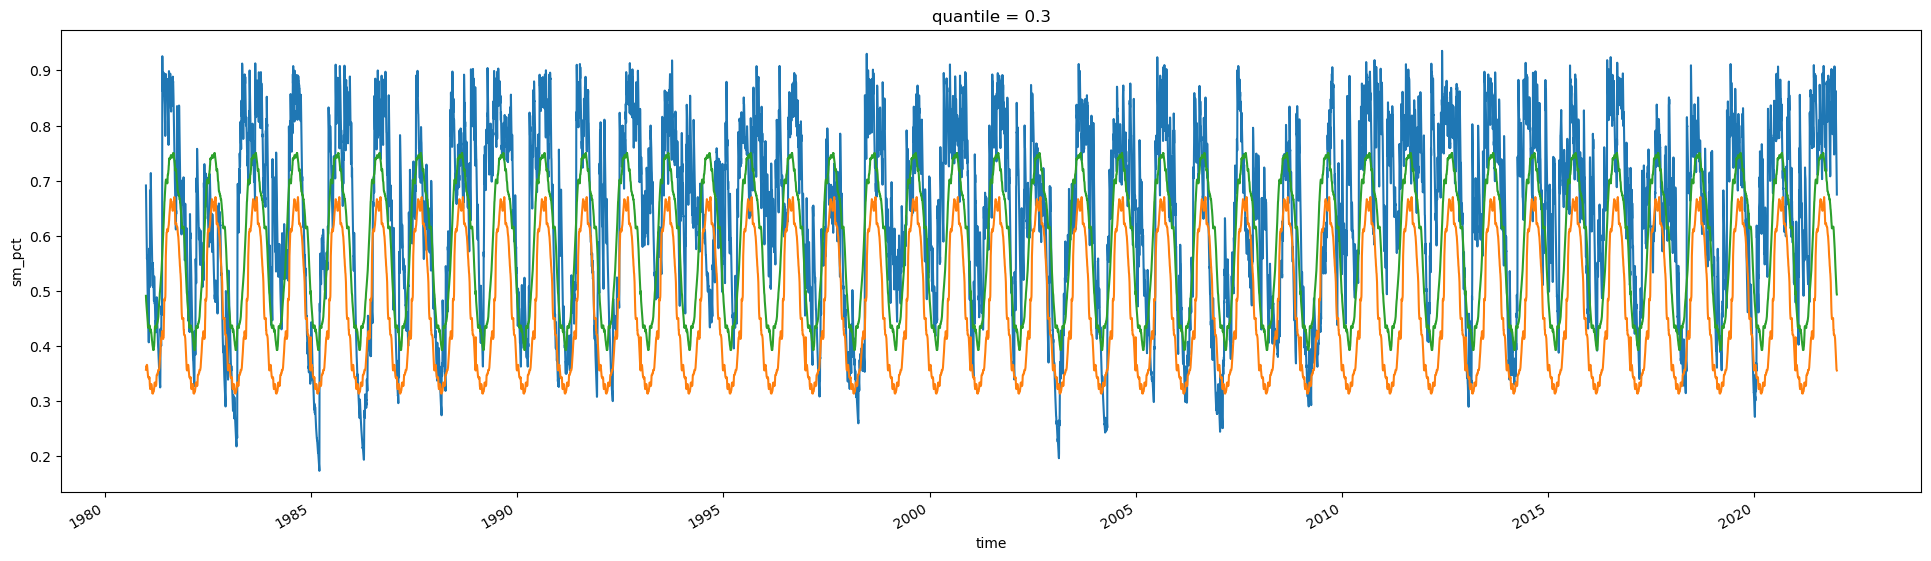

In [51]:
da_sm_yr['sm_pct'].plot(size = 6, aspect = 4)
da_sm_10p.plot()#.dayofyear.plot()
da_sm_30p.plot()

In [52]:
# criteria 1 : SM above 30th perc

da_sm_gt_30p = da_sm_yr['sm_pct'].where(da_sm_yr['sm_pct'] >= da_sm_30p)


In [53]:
da_sm_after_20days = da_sm_yr['sm_pct'].shift(time = -20)

In [54]:
da_sm_after_20days_lt_10p = da_sm_after_20days.where(da_sm_after_20days <= da_sm_10p)

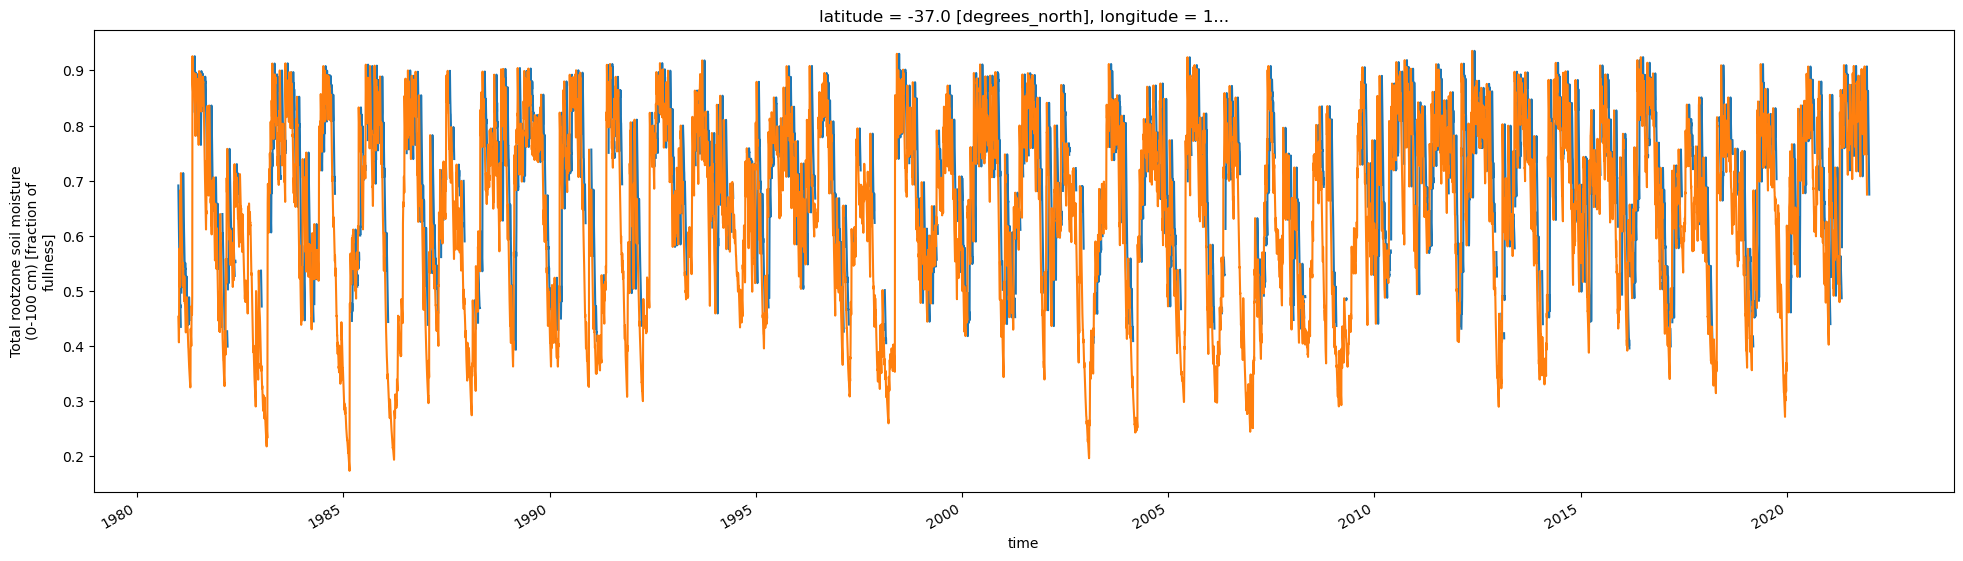

In [55]:
da_sm_gt_30p.plot(size = 6, aspect = 4)
da_sm_after_20days.plot()

In [56]:
da_sm_flash_drght = da_sm_gt_30p.where(~np.isnan(da_sm_after_20days))
da_sm_flash_drght

<xarray.DataArray 'sm_pct' (time: 14975)>
array([0.6912667 , 0.67356306, 0.65614074, ...,        nan,        nan,
              nan], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
    quantile   float64 0.3
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

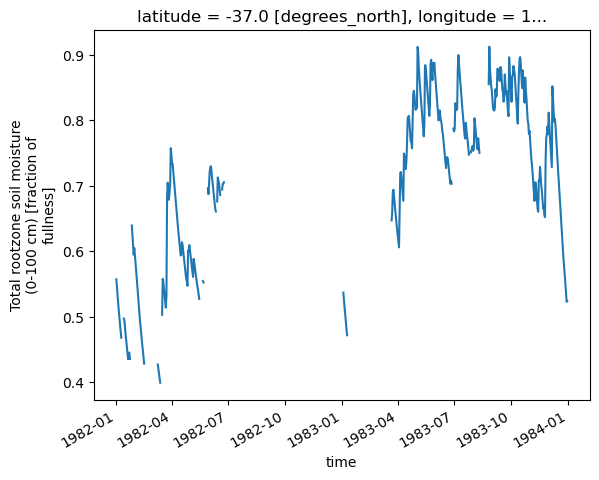

In [58]:
da_sm_flash_drght.sel(time = slice('1982', '1983')).plot()

In [32]:
da_sm_after_20days.values[0:5]

array([0.42645568, 0.44493395, 0.4355401 , 0.42563552, 0.42964604],
      dtype=float32)

In [33]:
da_sm_yr['sm_pct'].values[20:25]

array([0.42645568, 0.44493395, 0.4355401 , 0.42563552, 0.42964604],
      dtype=float32)

#### CDF of sm_pct

In [59]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF([3, 3, 1, 4])
ecdf([3, 55, 0.5, 1.5])

array([0.75, 1.  , 0.  , 0.25])

In [60]:
da_sm

<xarray.Dataset>
Dimensions:    (time: 14975)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Data variables:
    sm_pct     (time) float32 0.6913 0.6736 0.6561 ... 0.7105 0.6923 0.6748
Attributes:
    var_name:       sm_pct
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    url:            http://www.bom.gov.au/water/landscape
    title:          Australian Landscape Water Balance AWRA-L Model Version 6
    email:          awrams@bom.gov.au
    date_created:   2018-11-02T12:18:48
    source:         AWRA-L-v6)
    Description:    This data is provided by the Bureau of Meteorology and ca...
    date_modified:  2018-11-02T12:18:48

In [95]:
da_sm_6days_bef = da_sm.shift(time = -6)
da_sm_3days_bef = da_sm.shift(time = -3)
da_sm_6days_after = da_sm.shift(time = 6)
da_sm_3days_after = da_sm.shift(time = 3)

da_list = [da_sm_6days_bef, da_sm_3days_bef, da_sm, da_sm_3days_after, da_sm_6days_after]

da_sm_withWindow = xr.concat(da_list, dim = 'window')
doy_array = da_sm_withWindow['time.dayofyear']

ecdf_fn_list = []

for doy in range(1, 367):
    da_sm_sel = da_sm_withWindow.where(doy_array == doy_sel)
    da_sm_sel_nonNan = da_sm_sel['sm_pct'].values
    da_sm_sel_nonNan = da_sm_sel_nonNan[~np.isnan(da_sm_sel_nonNan)]
    ecdf = ECDF(da_sm_sel_nonNan)
    ecdf_fn_list.append(ecdf)

In [96]:
len(ecdf_fn_list)

366

In [102]:
# coverting soil mositure to percentiles

year_sel = '1983'
da_sm_sel = da_sm.sel(time = slice(year_sel, year_sel))

sm_perc_list = []
for doy, perc_fn in zip(da_sm_sel['time.dayofyear'].values, ecdf_fn_list):
    da_temp = da_sm_sel['sm_pct'].where(da_sm_sel['time.dayofyear'] == doy)
    temp_array = da_temp.values
    temp_array = temp_array[~np.isnan(temp_array)]
    print(temp_array)
    
    sm_perc = perc_fn(temp_array)
    sm_perc_list.append(sm_perc)

[0.39640802]
[0.4796376]
[0.53684187]
[0.5249146]
[0.51401335]
[0.50403607]
[0.4932586]
[0.48106632]
[0.4718198]
[0.46473926]
[0.4614078]
[0.46097517]
[0.45252964]
[0.44762516]
[0.43869275]
[0.42923814]
[0.419975]
[0.41130838]
[0.40281516]
[0.39399555]
[0.38545433]
[0.37705192]
[0.3693162]
[0.36319733]
[0.3617236]
[0.35516065]
[0.36414334]
[0.35652363]
[0.34893492]
[0.34154937]
[0.3342242]
[0.326908]
[0.32307547]
[0.32793614]
[0.32176998]
[0.31545454]
[0.30945817]
[0.3030239]
[0.2966481]
[0.29175213]
[0.28678453]
[0.28270593]
[0.30338755]
[0.31135353]
[0.30465174]
[0.2981232]
[0.2969967]
[0.29234296]
[0.28761795]
[0.2823644]
[0.27752018]
[0.27292305]
[0.2687915]
[0.3073518]
[0.30090773]
[0.29489276]
[0.2885299]
[0.2826639]
[0.2774473]
[0.27196938]
[0.26685762]
[0.26179308]
[0.25693753]
[0.25238168]
[0.24756196]
[0.2429494]
[0.2380823]
[0.23471121]
[0.2317465]
[0.2284282]
[0.22448952]
[0.2210184]
[0.21815202]
[0.25094065]
[0.2488322]
[0.24497475]
[0.24091077]
[0.23661132]
[0.23350711]
[

In [104]:
sm_perc_list2 = []
for i in sm_perc_list:
    sm_perc_list2.append(i[0])

In [105]:
sm_perc_list2

[0.1951219512195122,
 0.4146341463414634,
 0.5853658536585366,
 0.551219512195122,
 0.5073170731707317,
 0.47317073170731705,
 0.43414634146341463,
 0.4146341463414634,
 0.3902439024390244,
 0.375609756097561,
 0.37073170731707317,
 0.36585365853658536,
 0.35609756097560974,
 0.3463414634146342,
 0.3121951219512195,
 0.2975609756097561,
 0.25853658536585367,
 0.22439024390243903,
 0.2097560975609756,
 0.1951219512195122,
 0.18048780487804877,
 0.16585365853658537,
 0.16585365853658537,
 0.14146341463414636,
 0.13170731707317074,
 0.12682926829268293,
 0.14634146341463414,
 0.13170731707317074,
 0.12682926829268293,
 0.10243902439024391,
 0.0975609756097561,
 0.09268292682926829,
 0.0878048780487805,
 0.09268292682926829,
 0.07804878048780488,
 0.07317073170731708,
 0.06341463414634146,
 0.06341463414634146,
 0.05365853658536585,
 0.048780487804878044,
 0.04390243902439024,
 0.03414634146341463,
 0.06341463414634146,
 0.06829268292682927,
 0.06341463414634146,
 0.058536585365853655,
 0.

In [107]:
xr.DataArray?

Init signature:
xr.DataArray(
    data: 'Any' = <NA>,
    coords: 'Sequence[Sequence[Any] | pd.Index | DataArray] | Mapping[Any, Any] | None' = None,
    dims: 'Hashable | Sequence[Hashable] | None' = None,
    name: 'Hashable | None' = None,
    attrs: 'Mapping | None' = None,
    indexes: 'dict[Hashable, Index] | None' = None,
    fastpath: 'bool' = False,
) -> 'None'
Docstring:     
N-dimensional array with labeled coordinates and dimensions.

DataArray provides a wrapper around numpy ndarrays that uses
labeled dimensions and coordinates to support metadata aware
operations. The API is similar to that for the pandas Series or
DataFrame, but DataArray objects can have any number of dimensions,
and their contents have fixed data types.

Additional features over raw numpy arrays:

- Apply operations over dimensions by name: ``x.sum('time')``.
- Select or assign values by integer location (like numpy):
  ``x[:10]`` or by label (like pandas): ``x.loc['2014-01-01']`` or
  ``x.sel(time='20

In [108]:
da_sm_asPerc = xr.DataArray(sm_perc_list2, dims = ['time'], coords = {'time': da_sm_sel.time.values})

In [109]:
da_sm_asPerc

<xarray.DataArray (time: 365)>
array([0.19512195, 0.41463415, 0.58536585, 0.55121951, 0.50731707,
       0.47317073, 0.43414634, 0.41463415, 0.3902439 , 0.37560976,
       0.37073171, 0.36585366, 0.35609756, 0.34634146, 0.31219512,
       0.29756098, 0.25853659, 0.22439024, 0.2097561 , 0.19512195,
       0.1804878 , 0.16585366, 0.16585366, 0.14146341, 0.13170732,
       0.12682927, 0.14634146, 0.13170732, 0.12682927, 0.10243902,
       0.09756098, 0.09268293, 0.08780488, 0.09268293, 0.07804878,
       0.07317073, 0.06341463, 0.06341463, 0.05365854, 0.04878049,
       0.04390244, 0.03414634, 0.06341463, 0.06829268, 0.06341463,
       0.05853659, 0.05365854, 0.05365854, 0.04390244, 0.03414634,
       0.02926829, 0.02439024, 0.0195122 , 0.06341463, 0.05853659,
       0.05365854, 0.04390244, 0.03414634, 0.02926829, 0.0195122 ,
       0.0195122 , 0.0195122 , 0.01463415, 0.00487805, 0.00487805,
       0.00487805, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00487805, 0.00487805,
       0.00487805, 0.        , 0.        , 0.        , 0.10243902,
       0.84878049, 0.88780488, 0.91707317, 0.91707317, 0.91219512,
       0.90243902, 0.88780488, 0.86829268, 0.83414634, 0.8195122 ,
       0.8097561 , 0.79512195, 0.77073171, 0.88780488, 0.92682927,
       0.92682927, 0.92195122, 0.92195122, 0.91219512, 0.90243902,
...
       0.99512195, 0.99512195, 0.99512195, 0.99512195, 0.9902439 ,
       1.        , 1.        , 0.99512195, 0.99512195, 0.99512195,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99512195, 0.99512195, 0.99512195, 0.9902439 , 0.9902439 ,
       0.99512195, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99512195, 1.        , 0.99512195, 0.99512195,
       0.99512195, 1.        , 0.99512195, 0.99512195, 0.99512195,
       0.9902439 , 0.9902439 , 0.98536585, 0.9902439 , 0.98536585,
       0.96097561, 0.94634146, 0.93170732, 0.92682927, 0.92195122,
       0.91707317, 0.90243902, 0.92195122, 0.92195122, 0.91707317,
       0.90731707, 0.89268293, 0.88780488, 0.92195122, 0.92195122,
       0.93170732, 0.92682927, 0.92195122, 0.91707317, 0.90731707,
       0.89268293, 0.90243902, 0.87317073, 0.86829268, 0.94146341,
       0.98536585, 0.98536585, 0.9902439 , 0.98536585, 0.9902439 ,
       0.9902439 , 0.98536585, 0.97560976, 0.95121951, 0.93170732,
       0.99512195, 0.99512195, 0.9902439 , 0.9902439 , 0.9902439 ,
       0.9902439 , 0.98536585, 0.97073171, 0.94634146, 0.92682927,
       0.92195122, 0.91707317, 0.90731707, 0.89268293, 0.84878049,
       0.8195122 , 0.8       , 0.75121951, 0.71219512, 0.69756098,
       0.65365854, 0.6097561 , 0.58536585, 0.54146341, 0.55121951])
Coordinates:
  * time     (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31

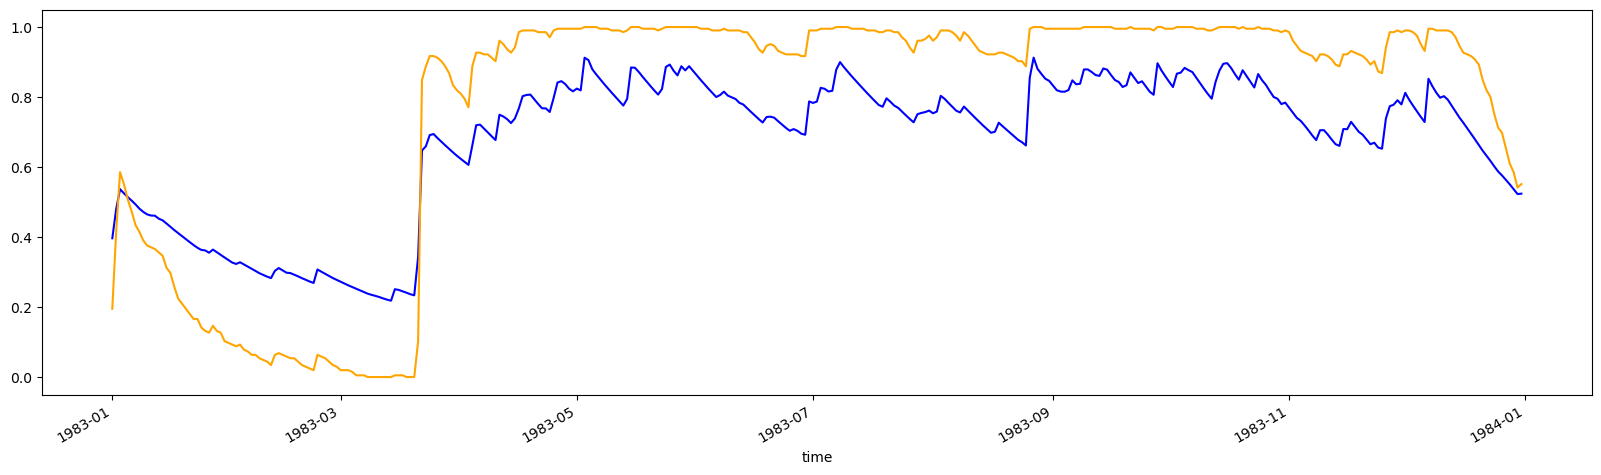

In [112]:
da_sm_sel['sm_pct'].plot(size = 5, aspect = 4, color = 'blue')
da_sm_asPerc.plot(color = 'orange')

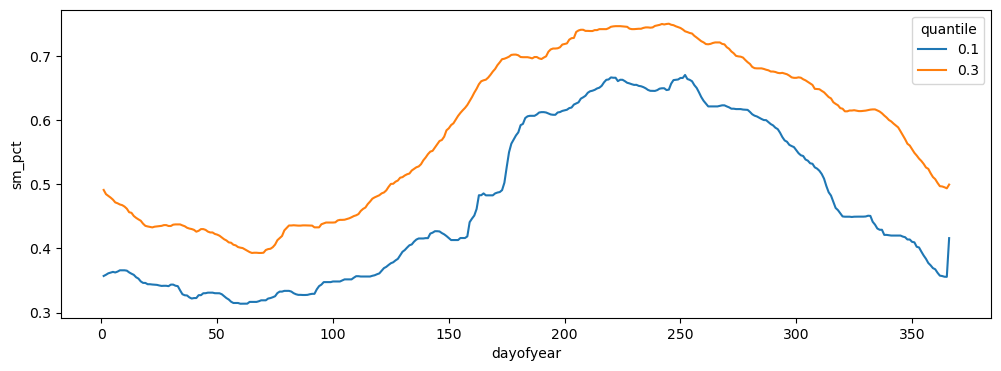

In [5]:
# quick plot of the calculated quantiles
ds_sm_pct_perc['sm_pct'].plot(size = 4, aspect = 3, hue = 'quantile')

In [6]:
# save the calculated data to a netcdf file for future use

out_dir = '/g/data/w97/ad9701/'
out_file = 'example_awra_sm_pct_quantiles.nc'
ds_sm_pct_perc.to_netcdf(out_dir + out_file)